In [1]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.preprocessing import Imputer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold

from sklearn.linear_model import Ridge

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, lars_path

In [2]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV


In [3]:
import xgboost as xgb

In [ ]:
#get the test data, #include Id
testdata = pd.read_csv("dummt_test_transformed.csv")

testdata.head()

testdata = testdata.drop(["Unnamed: 0"], axis = 1)

#### Get the training X and y

In [4]:
dummt_transformed = pd.read_csv("dummt_transformed.csv")

In [5]:
dummt_transformed.shape

(1460, 261)

In [7]:
#get y 
y = np.log(dummt_transformed['SalePrice'])

In [9]:
#Get X
X = dummt_transformed.drop(["Unnamed: 0", "SalePrice"], axis = 1)

In [10]:
X.shape

(1460, 259)

In [11]:
X.isnull().sum().sort_values()
#only LotFrontage has 259 NAs

MSSubClass                 0
BsmtQual_None              0
BsmtQual_TA                0
BsmtCond_Gd                0
BsmtCond_None              0
BsmtCond_Po                0
BsmtCond_TA                0
BsmtExposure_Gd            0
BsmtExposure_Mn            0
BsmtExposure_No            0
BsmtExposure_None          0
BsmtFinType1_BLQ           0
BsmtFinType1_GLQ           0
BsmtFinType1_LwQ           0
BsmtQual_Gd                0
BsmtFinType1_None          0
BsmtFinType1_Unf           0
BsmtFinType2_BLQ           0
BsmtFinType2_GLQ           0
BsmtFinType2_LwQ           0
BsmtFinType2_None          0
BsmtFinType2_Rec           0
BsmtFinType2_Unf           0
Heating_GasA               0
Heating_GasW               0
Heating_Grav               0
Heating_OthW               0
Heating_Wall               0
HeatingQC_Fa               0
BsmtFinType1_Rec           0
                        ... 
Neighborhood_NPkVill       0
Neighborhood_NWAmes        0
Neighborhood_NoRidge       0
Neighborhood_N

In [12]:
#replace NAs with the mean using Imputer
imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imp = imp.fit(X)
X_imp = imp.transform(X)

#### Tune Random Forest

In [27]:
rfr_model = RFR()
cross_validation = StratifiedKFold(n_splits = 10, shuffle = False, random_state = None)
parameter_grid = {"n_estimators":np.arange(10, 100, 10), "max_depth": range(5,10)}

grid_search = GridSearchCV(rfr_model, param_grid=parameter_grid, cv=cross_validation, n_jobs=4)
grid_search.fit(X_imp, y)
print grid_search.best_score_
print grid_search.best_params_

KeyboardInterrupt: 

#### Output
print grid_search.best_score_
0.796586507627
print grid_search.best_params_
{'n_estimators': 60, 'max_depth': 9}

#### Fit Random forest using the best parameters

In [33]:
rfr = RFR(n_estimators = 60, max_depth = 9)
rfr.fit(X_imp, y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [34]:
mse = np.mean((y - rfr.predict(X_imp))**2)

In [35]:
mse

0.0048862276756118685

In [36]:
#Predict y using test data
ypred = rfr.predict(testdata.iloc[:,1:])

ypred_final = np.exp(ypred)

sub1 = pd.concat([testdata.loc[:,"Id"],pd.Series(ypred_final)], axis = 1)

sub1.columns = ["Id", "SalePrice"]

In [38]:
sub1.to_csv("Submission2.csv")

#### Select the feature_importances_

In [39]:
#Get the feature_importances_
fea_import = pd.DataFrame(rfr.feature_importances_, index = X.columns, columns = ["Feature_Importance"]).sort_values(by = "Feature_Importance", ascending = True)
fea_import.tail(10)

,Feature_Importance
OverallCond,0.012152
CentralAir_Y,0.012568
YearBuilt,0.015900
GarageArea,0.019841
BsmtFinSF1,0.021724
1stFlrSF,0.021792
GarageCars,0.040192
TotalBsmtSF,0.045672
GrLivArea,0.113811
OverallQual,0.564396


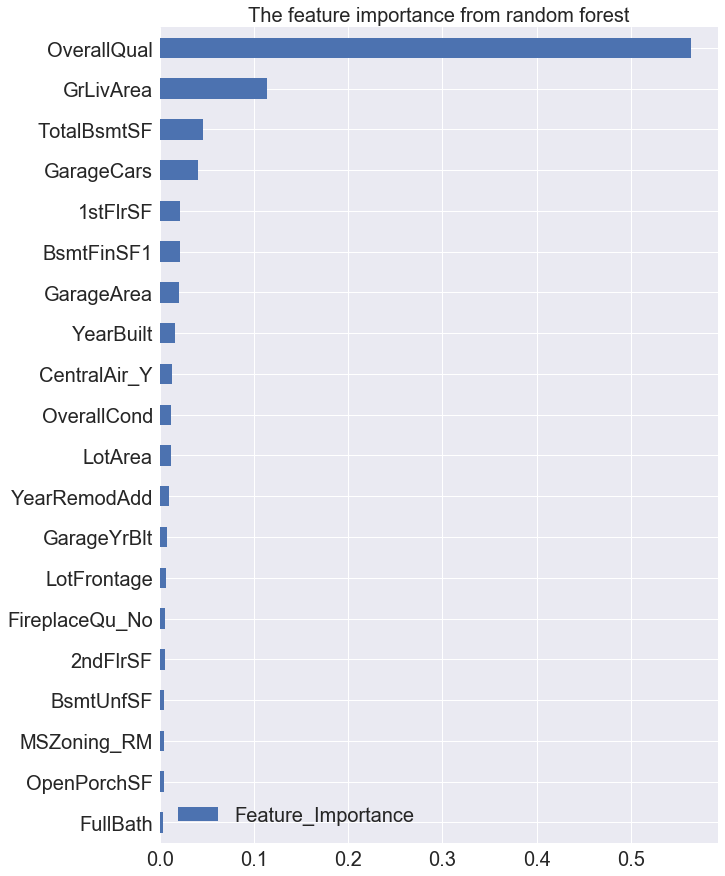

In [46]:
#plot the feature importance
ax = fea_import.iloc[-20:, :].plot.barh(figsize = (10,15),fontsize = 20)
ax.set_title("The feature importance from random forest", fontsize = 20)
ax.legend(fontsize = 20)

In [47]:
#select top35
top20 = fea_import.index[-20:]

In [48]:
#subset X for ridge regression
X_ri = X[top20]

In [49]:
#replace the NaN with mean
imp = imp.fit(X_ri)
X_ri = imp.transform(X_ri)

#### Tune and Fit Ridge regression using the selected top 35 features

In [50]:
alphas = np.logspace(-6,4,11)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(X_ri,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)
#zip(alphas,LOOr)

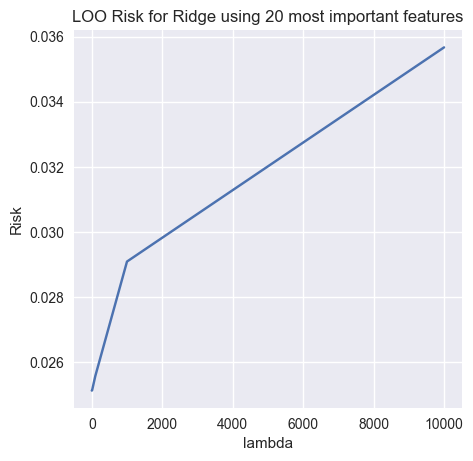

In [52]:
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge using 20 most important features')
#plt.xlim([0,20])
#plt.ylim([0.006,0.010])
plt.show()

In [53]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])
#the minimum MSE is 0.02584

(1.0, 0.025125787613714971)

#### Tune and fit Xgboost regression

In [58]:
#use xgboost
xgb_model = xgb.XGBRegressor()
cross_validation = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
parameter_grid = {'max_depth': range(5,10), 'n_estimators': np.arange(10,100,10)}
xgbgrid = GridSearchCV(xgb_model, param_grid=parameter_grid, cv=cross_validation) 
xgbgrid.fit(X_imp,y)
print xgbgrid.best_score_
print xgbgrid.best_params_


0.838368665831
{'n_estimators': 90, 'max_depth': 5}


In [13]:
xgbm = xgb.XGBRegressor(max_depth = 5, n_estimators = 90)
xgbm.fit(X_imp, y)

XGBRegressor(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=90, nthread=-1, objective='reg:linear', seed=0,
       silent=True, subsample=1)

In [18]:
ypred = xgbm.predict(testdata.iloc[:,1:])

ypred_final = np.exp(ypred)

sub = pd.concat([testdata.loc[:,"Id"],pd.Series(ypred_final)], axis = 1)

sub.columns = ["Id", "SalePrice"]

In [31]:
sub.to_csv("Submission.csv")